# Activity 3.1 Perceptron
In this activity, you learn how to generate synthetic data for binary classification problem and build your perceptron model based on that. Having a synthetic data is very helpful in studying the performance of a certain algorithm in different scenarios. In Assessment 2, you will be asked to expand the algorithm you have learned in this activity in order to solve multi-class classification problems.

## Synthetic Dataset
In this and other activities of Module 3, we work on our own synthetic data. This makes it easier to study the model we develop and validate the obtained results.

To generate such synthetic data using a statistical procedure, wee should first decide on some parameters (generative parameters). In a binary classification problem, an option is to suppose the data points are sampled from two gaussian distributions. For example, assume $\mu_0 = \{4.5, 0.5\} $ and $\mu_1 = \{1.0, 4.0\}$ and a shared covariance matrix: 
\begin{equation*}
\Sigma = 
\begin{pmatrix}
1 & 0\\
0 & 1\\
\end{pmatrix}
\end{equation*}

Using these parameters, we can easily generate any number of data points we need. Note that, in this example we assumed an *Identity* covariance metrix $\pmb{I}$. Later on, we also study non-identity (*Diagonal* and *Non-diagonal*) matrices. 

In [1]:
## Generative parameters
# class labels
c0 <- '+1'; c1 <- '-1' 
mu0 <- c(4.5, 0.5)
mu1 <- c(1.0, 4.0)

# Model the probability
p0 <- 0.60; p1 <- 1 - p0

# covariance matrix
sigma <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE)
# share
sigma0 <- sigma
sigma1 <- sigma

# an examle of nonshared covariance matrices (QDA?)
#sigma0 <- matrix(c(0.2, 0.2, 0.2, 0.2), nrow=2, ncol=2, byrow = TRUE)
#sigma1 <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE)

### Generation Process

Now, let's generate $N=1000$ samples by:
<ol>
    <li> Randomly select one of the classes (e.g., by probability 0.6 vs 0.4),</li>
   <li> Generate one random sample from the selected distribution,</li>
   <li> Add the generated sample and its class label to the training dataset,</li>
   <li> Repeat the above steps until $N$ samples are generated,</li>  
</ol>

In [2]:
# Generation Process
## Libraries:
library(MASS) # generates multivariate Gaussian sampels
library(ggplot2)
library(reshape2)

`mvrnorm(n = 1, mu, Sigma, tol = 1e-6, empirical = FALSE, EISPACK = FALSE)`  
Produces one or more samples from the specified multivariate normal distribution.

* `n`: the number of samples required.
* `mu`:	a vector giving the means of the variables.
* `Sigma`:	a positive-definite symmetric matrix specifying the covariance matrix of the variables.
* `tol`: tolerance (relative to largest variance) for numerical lack of positive-definiteness in Sigma.
* `empirical`: logical. If true, mu and Sigma specify the empirical not population mean and covariance matrix.
* `EISPACK`: logical, values other than FALSE are an error.

In [4]:
## Initialization
set.seed(8092018)
N <- 1000
# initialise empty data.frame
data <- data.frame(x1=double(), x2=double(), label=factor(levels = c(c0,c1)))

# Generate class labels (Step 1)
data[1:N,'label'] <- sample(c(c0,c1), N, replace = TRUE, prob = c(p0, p1))

# calculate the size of each class 
N0 <- sum(data[1:N,'label']==c0); N1 <- N - N0

# Sample from the Gaussian distribution accroding to the class labels and statitics. (Steps 2 & 3)
data[data[1:N,'label']==c0, c('x1', 'x2')] <- mvrnorm(n = N0, mu0, sigma0)
data[data[1:N,'label']==c1, c('x1', 'x2')] <- mvrnorm(n = N1, mu1, sigma1)

Now, we divide the generated samples into training and testing sets.

In [5]:
## Split data into half: 
train.len <- round(N/2)
train.index <- sample(1:N, train.len, replace = FALSE)

# training datasets
train.data <- data[train.index, c('x1', 'x2')]
train.label <- data[train.index, 'label']

# testing datasets
test.data <- data[-train.index, c('x1', 'x2')]
test.label <- data[-train.index, 'label']

### Visualization of The Generated Data
Let's create a scatter plot to see the generated points.

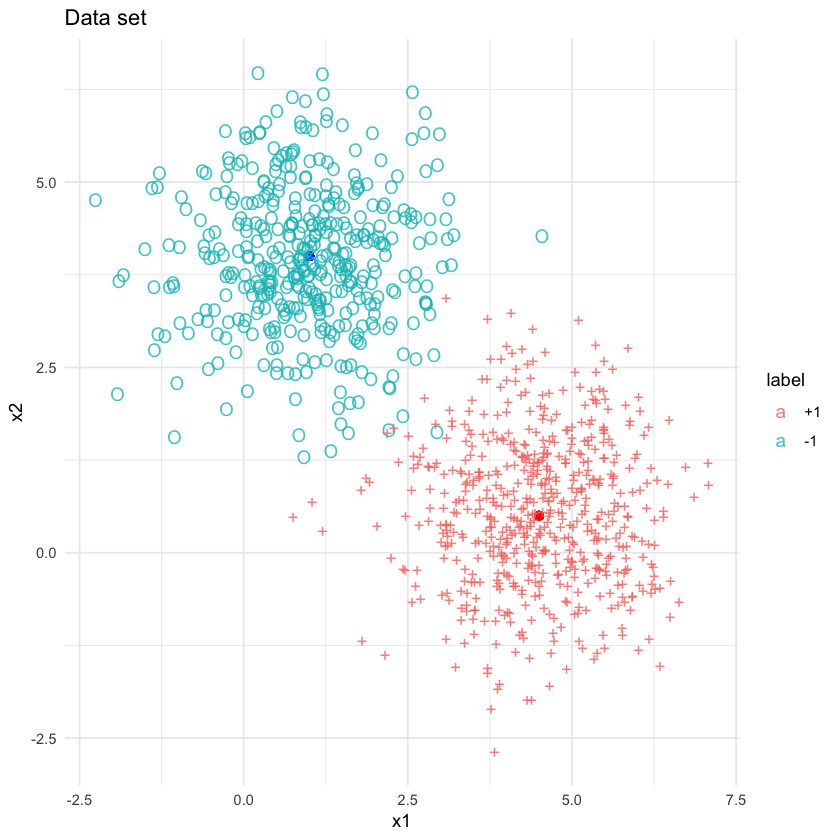

In [37]:
## Take a look at the data set
ggplot(data=data, aes(x=x1, y=x2, color=label, label=ifelse(label==c0, '+', 'O'))) +
    geom_point(x=mu0[1], y=mu0[2], size=2, color = 'Red') +
    geom_point(x=mu1[1], y=mu1[2], size=2, color = 'Blue') +
    geom_text(size = 4, alpha=0.8) +
    ggtitle ('Data set') +
    theme_minimal()

# The Perceptron
## Steps for Building Perceptron
Assuming the class labels are $\boxed{+1}$ and $\boxed{-1}$, we take the following steps to build a perceptron:

1. Choose and implement a basis function $\pmb{\phi}$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping threshold $\epsilon$,

2. Use the above function and repeat the following until the improvement is small (i.e., $|E(\pmb{w}^{(\tau+1)})-E(\pmb{w}^{(\tau)})| < \epsilon$):

* Shuffle the training data

* For each datapoint in the training data do:

 + Classify the sample using the current weight vector,

 + If the sample correctly classified, pick the next point (continue the loop)

 + If the sample misclassified, update the weight vector as $\pmb{w}^{\tau+1} := \pmb{w}^{\tau} + \eta\phi(\pmb{x}_n) t_n$

Seems easy! Let's do it step by step!

The following implements a simple linear basis fucntion. This is basically an identity function plus $1$ (the intercept will multiplied to this $1$)

In [13]:
## Basis function (Step 1)
Phi <- as.matrix(cbind(1, train.data)) # add a column of 1 as phi_0 (the bias)

Before going further, let's set the parameters. We also need to create some empty matrices for future uses.

In [14]:
# Initialization
eta <- 0.01 # Learning rate
epsilon <- 0.001 # Stoping criterion
tau.max <- 100 # Maximum number of iterations

# Convention for class labels: 
# c0 = '+1' -> eval(parse(text=c0)) -> 1
T <- ifelse(train.label == c0, eval(parse(text=c0)), eval(parse(text=c1))) 

# Empty Weight vector
W <- matrix(,nrow=tau.max, ncol=ncol(Phi))
# Randomly generate initial values for weight vector
# Note: Perceptron is sensitive to initial value
W[1,] <- runif(ncol(Phi))

# Placeholder for errors
error.trace <- matrix(0,nrow=tau.max, ncol=1)

# record error for initial weights
error.trace[1] <- 100 * sum((Phi%*%W[1,])*T<0) / train.len

tau <- 1 # iteration counter 
terminate <- FALSE # termination status

The following is the main loop where we learn the model paramters using SGD.

In [29]:
# Main Loop (Step 2):
while(!terminate){
    # resuffling train data and associated labels:
    train.index <- sample(1:train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]

    for (i in 1:train.len){
        if (tau == tau.max) {break}
              
        # look for missclassified samples
        if ((W[tau,]%*%Phi[i,])*T[i]<0){
            
            # update tau counter
            tau <- tau +1
            
            # update the weights
            W[tau,] <- W[tau-1,] + eta * Phi[i,] * T[i]
            
            # update the records
            error.trace[tau] <- sum((Phi%*%W[tau,])*T<0)/train.len*100
        } 
        
    }
    
    # decrease eta:
    eta = eta * 0.99
    
    # recalculate termination conditions
    current_expect_error = sum((Phi%*%W[tau,])*T<0)/train.len
    last_expect_error = sum((Phi%*%W[tau-1,])*T<0)/train.len
    expect_error_diff = abs(current_expect_error-last_expect_error)
    
    cond1 <- tau >= tau.max
    cond2 <- (expect_error_diff <= epsilon) 
    terminate <- cond1 | cond2
}
W <- W[1:tau,] # cut the empty part of the matrix (when the loop stops before tau == tau.max)

Done! Let's print the learnt weight vector.

In [30]:
## the  final result is w:
w <- W[tau,]
## report
cat('\nThe  final weight vector:', w)


The  final weight vector: 0.4289519 0.2036475 -0.4264762

## Visualizations
Time for visualizations. Here we visualize the datapoints and the decision boundary.

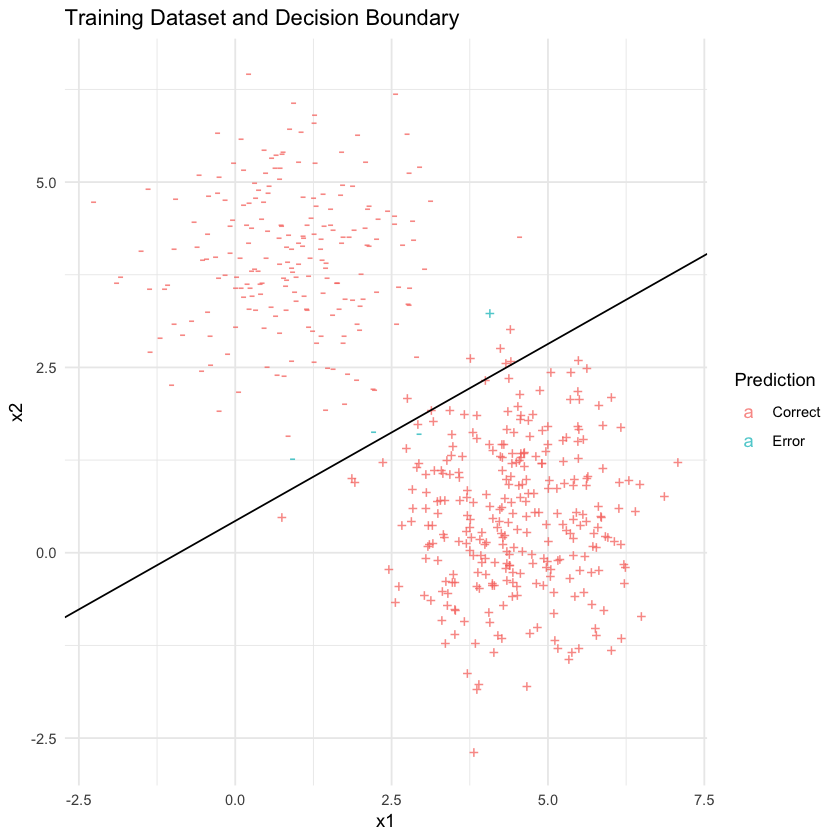

In [52]:
# Visualizations
## Ploting the decision boundary
pred <- ifelse(Phi%*%w*T>0, 'Correct', 'Error')
ggplot(data=as.data.frame(Phi), aes(x=x1, y=x2, label=ifelse(T!=c1, '+', '-'), color=factor(pred))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    geom_abline(intercept=w[1], slope=-w[2]/w[3]) +
    ggtitle('Training Dataset and Decision Boundary') +
    theme_minimal()

Here we plot the training error rate as the perceptron learns the weight vector.

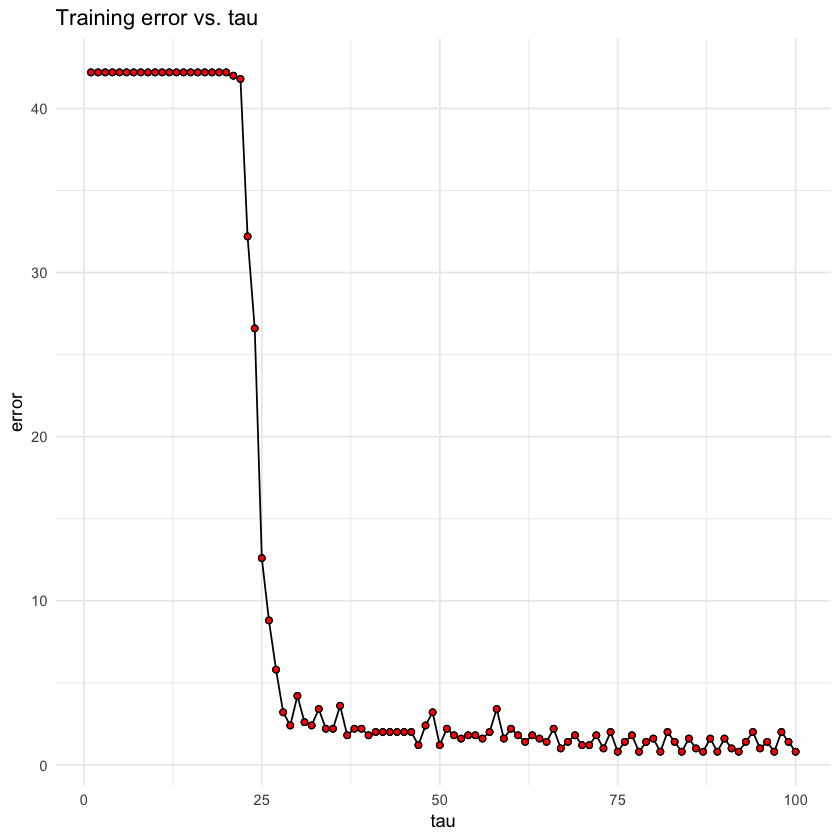

In [53]:
## merging and melting for visualizations
out <- data.frame('tau'=1:tau)
out$error <- error.trace[1:tau]
out[,c('w0', 'w1', 'w2')] <- W

out.m <- melt(out, id=c('tau', 'error'))
names(out.m) <- c('tau', 'error', 'W', 'coefficient')

## Training error
ggplot(data=out.m,aes(x=tau, y=error)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Training error vs. tau') + theme_minimal()

## Discussions

1- How can we modify the error function to prevent overfitting? **Hint:** consider using a validation set.

2- How the learning rate `eta` can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other initial values for learning rate and investigate their effects.

3- In the above example, we only studied a very simple problem. Challenge the perceptron by trying different covariance for each class ($\Sigma_0$ != $\Sigma_1$)

4- In many applications (cancer diagnosis for example), missclassifying the samples of one class has much bigger cost than the others (that class could be the smallest class as well). How you can involve the missclassification costs into the Perceptron to minimize these costs instead of the number of missclassified samples?